In [1]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("shashwatwork/knee-osteoarthritis-dataset-with-severity")

In [2]:
train_dir = os.path.join(path, "train")
val_dir = os.path.join(path, "val")
test_dir = os.path.join(path, "test")

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

batch_size = 32
img_size = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=img_size,
    batch_size=batch_size
)

# Optional: Normalize like torchvision
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))


Found 5778 files belonging to 5 classes.
Found 826 files belonging to 5 classes.
Found 1656 files belonging to 5 classes.


In [20]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='leaky_relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

learning_rate = 0.0005  # Example learning rate

optimizer = Adam(learning_rate=learning_rate)


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


In [19]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.3473 - loss: 1.6622 - val_accuracy: 0.2530 - val_loss: 8.3652
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 57s 312ms/step - accuracy: 0.3794 - loss: 1.4262 - val_accuracy: 0.3971 - val_loss: 1.4101
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 325ms/step - accuracy: 0.3847 - loss: 1.4154 - val_accuracy: 0.3971 - val_loss: 1.4031
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 56s 308ms/step - accuracy: 0.3841 - loss: 1.4112 - val_accuracy: 0.3983 - val_loss: 1.3963
Epoch 5/10
142/181 ━━━━━━━━━━━━━━━━━━━━ 11s 297ms/step - accuracy: 0.3814 - loss: 1.4143

KeyboardInterrupt: 

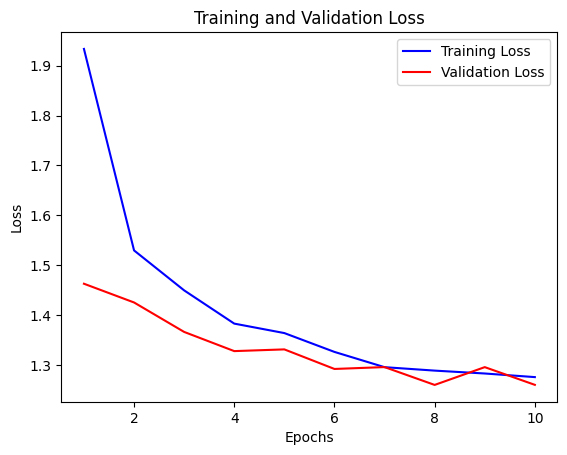

In [15]:
# prompt: Create a graph of validation loss vs training loss

import matplotlib.pyplot as plt

# Assuming 'history' object contains the training history from model.fit
# history = model.fit(...)

# Access training and validation loss values
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']

# Create the plot
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
